# <center> CLASE DE BOTS </center>
## <center> Nicolas Pacheco </center>
#### <center> https://x.com/nicopachecolas </center>

## Contenido

#### Bot
* Datos del bot relevantes
* Estrategia

#### Diagrama

#### Qué veremos en la clase?
* Pycharm
* Telegram
* Google sheets
* Api exchange
* Funciones varias
* Indicadores
* Main
* Bot corriendo


### BOT
- Mercado Crypto
- Time frame 1 hora
- Direccional en base a indicadores
- Dos estrategias simples para dos estados de mercado diferentes
- Con stop loss y take profit
- Alertas en telegram
- Base de datos en google sheets
- Utilizaremos el exchange OKX
- Enviaremos ordenes en paper trading (mercado de prueba)

### DIAGRAMA

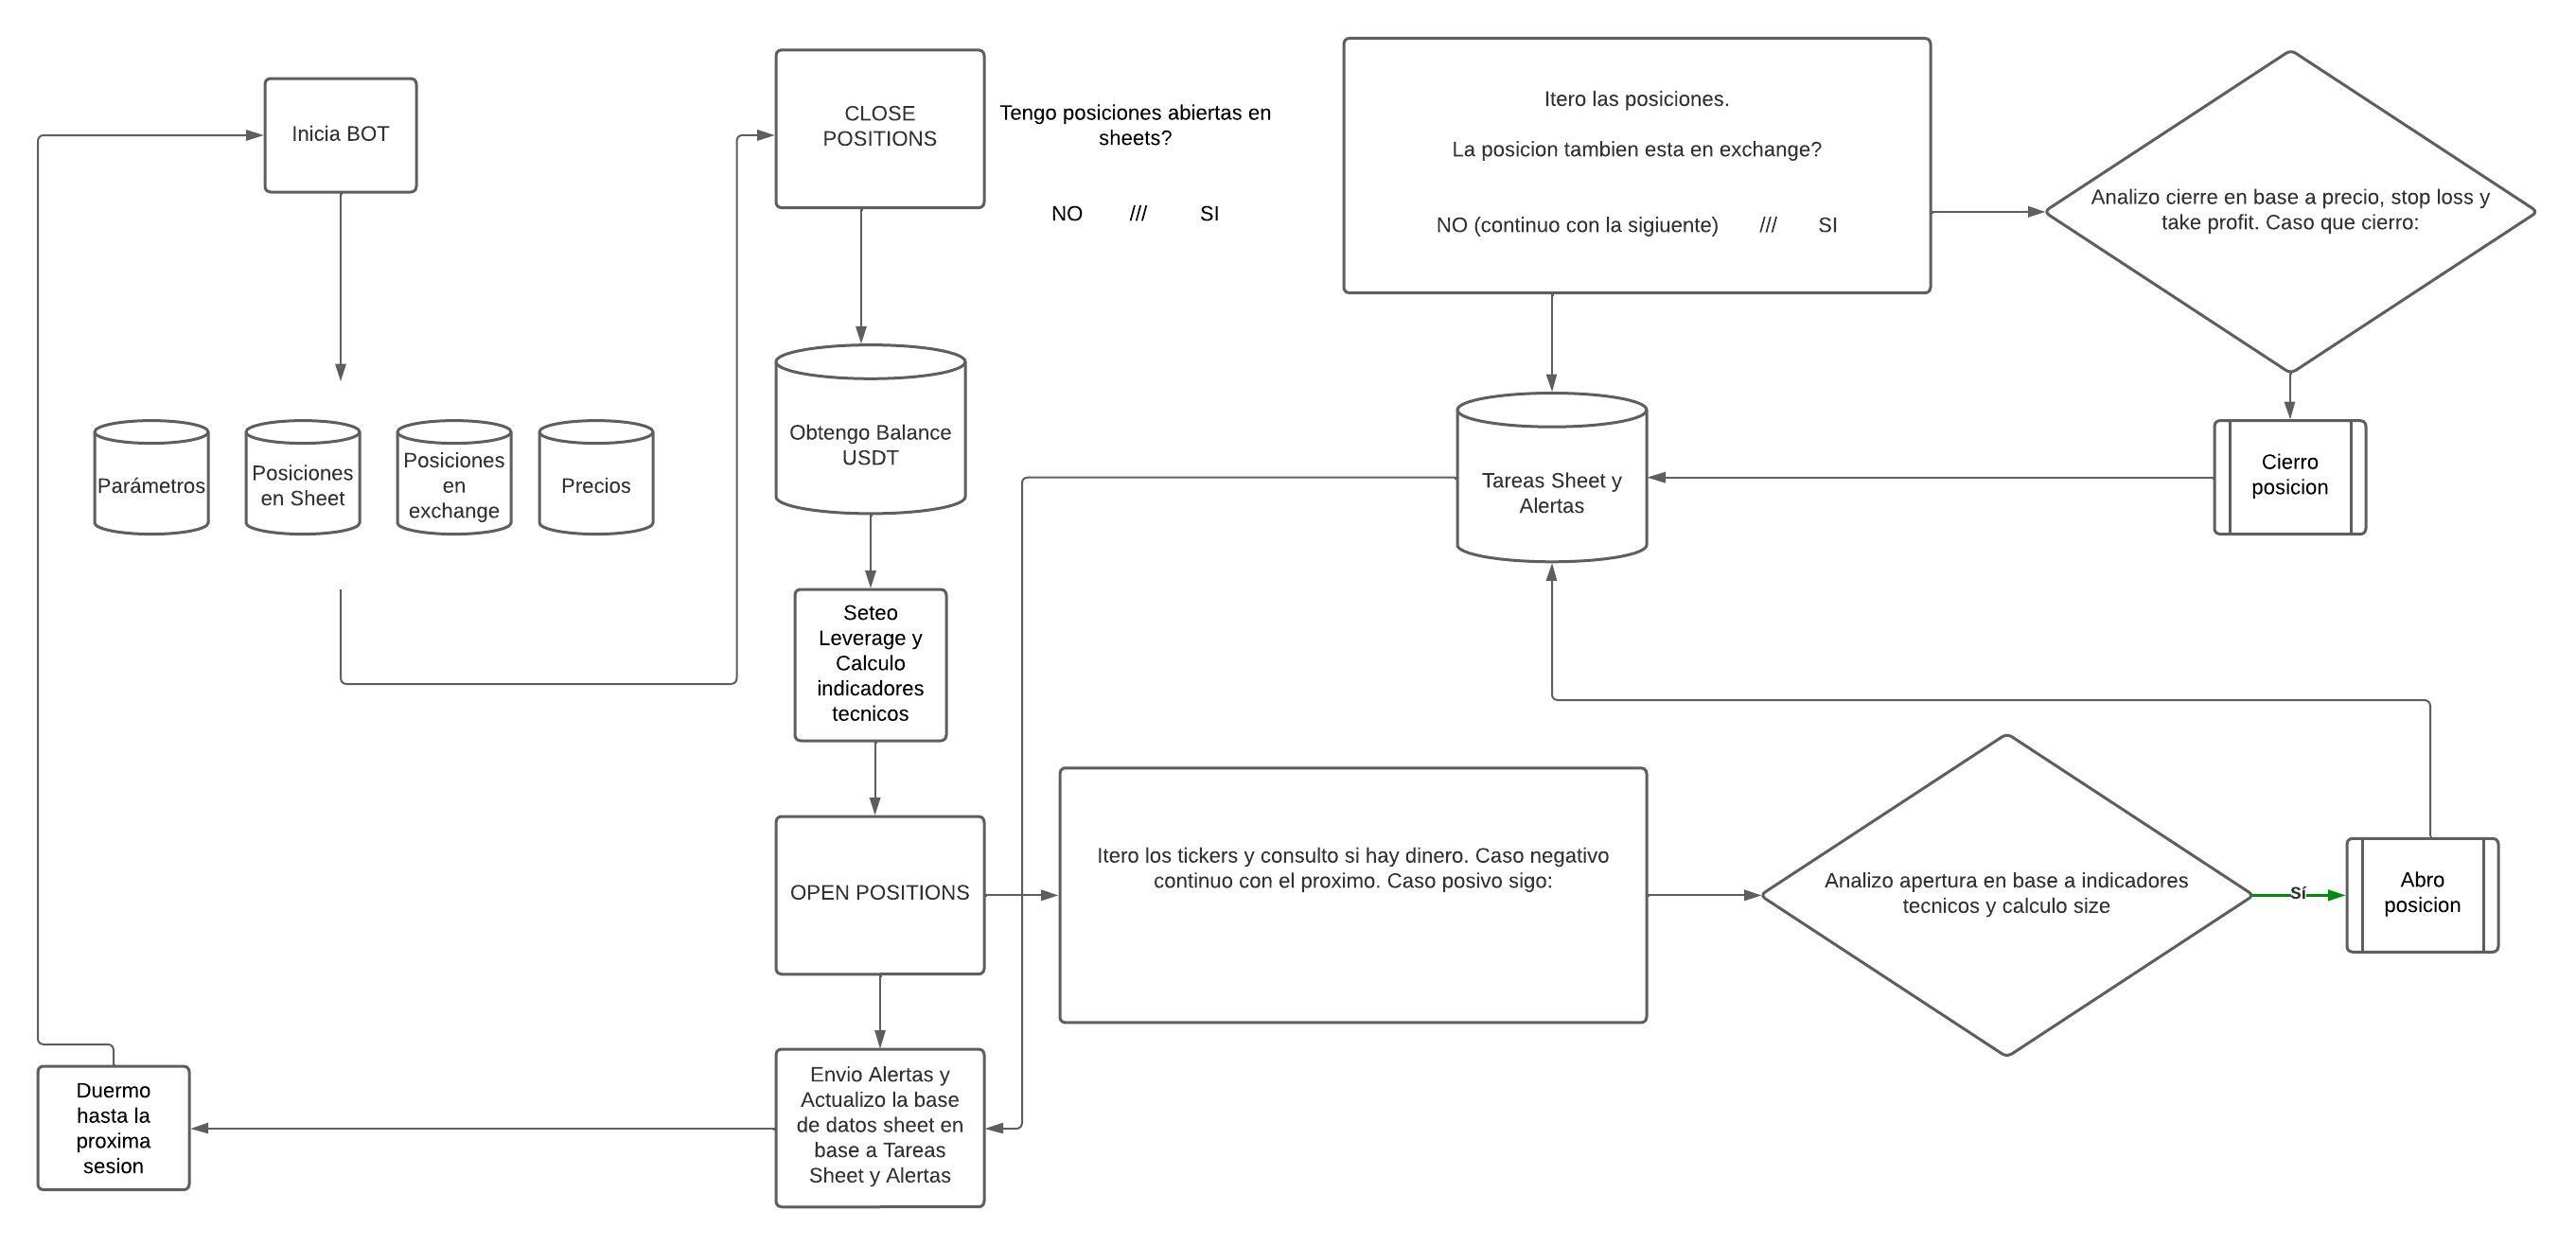

In [2]:
from IPython.display import Image
Image(filename='diagrama.jpeg')

# Pycharm

PyCharm es un Entorno de Desarrollo Integrado (IDE) específicamente diseñado para Python.

### Previo a arrancar, 
Voy a dejar las credenciales en esta celda, en el archivo quedarán vacias, ustedes deberán sacar las suyas. Estará todo explicado paso a paso



In [3]:
# Credenciales
BOT_TOKEN = '6291645210:AAEQDw0ZKQIZMvK7Uk1DYjvv4CEU_cqZ60U'
CHAT_ID_LIST = ['805892439']

API_KEY = ""
API_SECRET = "" 
PASSPHRASE = 'Ucema_2024'

# Config
FILE_JSON = 'ucema-bot-f4320e375ca1.json'
FILE_SHEET = 'ucema_bot'
HOJA_PARAMETROS = 'parametros'
HOJA_OPERACIONES = 'operaciones'
HOJA_POSICIONES = 'posiciones'
HOJA_TESTEO = 'testeo'


In [15]:
# Instalar librerias
!pip install gspread==6.1.2
!pip install pandas==2.2.2
!pip install Requests==2.32.3
!pip install ta==0.11.0
!pip install python-okx==0.3.2



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached python-okx-0.3.2.tar.gz (24 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for importlib-metadata from https://files.pythonhosted.org/packages/82/47/bb25ec04985d0693da478797c3d8c1092b140f3a53ccb984fbbd38affa5b/importlib_metadata-8.2.0-py3-none-any.whl.metadata
  Using cached importlib_metadata-8.2.0-py3-none-any.whl.metadata (4.7 kB)
  Obtaining dependency information for keyring from https://files.pythonhosted

# Telegram

### Pasos para crear un bot de Telegram:
1. Busca el usuario @BotFather en Telegram.
2. Inicia una conversación y escribe /newbot
3. Sigue las instrucciones para crear tu bot:
   - Elige un nombre para tu bot
   - Elige un nombre de usuario para tu bot (debe terminar en 'bot')
4. BotFather te dará un **token de acceso**. Guárdalo de forma segura.
5. Inicia una conversación con tu nuevo bot y envía el comando /start
        
Para obtener tu chat_id:
1. Busca el bot @userinfobot en Telegram
2. Inicia una conversación y envía cualquier mensaje
3. El bot te responderá con tu información, incluyendo tu **chat_id**
        
El bot creado para esta clase es: t.me/ucema_alertas_bot

In [10]:
import requests


def send_telegram_message(bot_token, message, chat_id_list):
    """
    Envía un mensaje a uno o varios chats de Telegram.

    :param bot_token: Token del bot de Telegram (string)
    :param message: Mensaje a enviar
    :param chat_id_list: Lista de chat_ids a los que se enviará el mensaje
    """

    message = str(message)  # Convierto el mensaje a string

    for chat_id in chat_id_list:

        chat_id = str(chat_id)  # Convierto el chat_id a string

        try:
            # Construimos la URL para la API de Telegram usando f-strings
            send_text = 'https://api.telegram.org/bot' + bot_token + \
                        '/sendMessage?chat_id=' + chat_id + '&parse_mode=Markdown&text=' + message

            response = requests.get(send_text)  # Enviamos la solicitud GET a la API de Telegram

            response.raise_for_status()  # Verificamos si la solicitud fue exitosa

            print(f"Mensaje enviado exitosamente al chat_id: {chat_id}")

        except requests.RequestException as e:
            print(f"Error al enviar mensaje de Telegram al chat_id {chat_id}: {e}")

In [16]:
# Ejemplo de cómo usar la función
send_telegram_message(BOT_TOKEN, 'Long BTC', CHAT_ID_LIST)

Mensaje enviado exitosamente al chat_id: 805892439


# Google Sheets

### Instrucciones para configurar Google Sheets:
1. Generar un proyecto en la consola de Google Cloud: https://console.cloud.google.com/
2. Habilitar la API de Google Sheets para el proyecto.
3. Crear una cuenta de servicio y descargar el **archivo JSON** de credenciales.
4. Compartir el Google Sheet con el correo de la cuenta de servicio.

Para el proceso completo y mejor explicado, consultar este hilo de twitter que hice hace un tiempo:
https://x.com/nicopachecolas/status/1633568913844781058
    
Con dicho proceso obtienen un json y un correo para compartir el sheet a utilizar.
Este json **debe** estar accesible en el repositorio. En pycharm lo dejé en la misma carpeta donde están todos los archivos python. En jupyter deberían dejarlo también en la misma carpeta de este archivo.

En este caso el sheet que vamos a utilizar es "ucema_bot", link:
https://docs.google.com/spreadsheets/d/1YotU4XUKp4AslkM3gdeEtH_u3kJHWBGuhMWuPyUoBy8/edit?usp=sharing

Hojas utilizadas:
- parametros
- posiciones
- operaciones


In [66]:
# Funciones que utilizaremos


import gspread
from google.auth.exceptions import GoogleAuthError
from gspread.exceptions import SpreadsheetNotFound, WorksheetNotFound
import pprint
from typing import List, Dict, Any


def get_google_sheet(file_json: str, g_sheet: str) -> gspread.Spreadsheet:
    """
    Obtiene el objeto Google Sheet para acceder a las hojas de cálculo.

    :param file_json: Ruta al archivo JSON con las credenciales de Google Sheets
    :param g_sheet: Nombre del Google Sheet
    :return: Objeto Spreadsheet de gspread
    :raises GoogleAuthError: Si hay un problema con la autenticación
    :raises SpreadsheetNotFound: Si no se encuentra el Google Sheet especificado
    """

    try:
        gc = gspread.service_account(filename=file_json)
        sh = gc.open(g_sheet)
        return sh
    except GoogleAuthError as e:
        print(f"Error de autenticación: {e}")
        raise
    except SpreadsheetNotFound:
        print(f"No se encontró el Google Sheet '{g_sheet}'")
        raise


def get_sheet(sh: gspread.Spreadsheet, sheet_name: str) -> gspread.Worksheet:
    """
    Obtiene una hoja de cálculo específica del Google Sheet.

    :param sh: Objeto Spreadsheet de gspread
    :param sheet_name: Nombre de la hoja de cálculo
    :return: Objeto Worksheet de gspread
    :raises WorksheetNotFound: Si no se encuentra la hoja especificada
    """
    try:
        return sh.worksheet(sheet_name)
    except WorksheetNotFound:
        print(f"No se encontró la hoja '{sheet_name}'")
        raise


def read_all_sheet(gs: gspread.Spreadsheet, sheet_name: str) -> List[Dict[str, Any]]:
    """
    Lee todos los datos de una hoja y los devuelve como una lista de diccionarios.

    :param gs: Objeto Spreadsheet de gspread
    :param sheet_name: Nombre de la hoja de cálculo
    :return: Lista de diccionarios con los datos de la hoja
    """
    sheet = get_sheet(gs, sheet_name)
    return sheet.get_all_records()


def add_position(gs: gspread.Spreadsheet, data: Dict[str, Any], sheet_name: str = 'posiciones') -> None:
    """
    Agrega una nueva posición a la hoja de posiciones.

    :param gs: Objeto Spreadsheet de gspread
    :param data: Diccionario con los datos de la posición
    :param sheet_name: Nombre de la hoja de posiciones (por defecto 'posiciones')
    """

    # reorganizo los datos para que coincidan con las columnas
    columns = ['ticker', 'execution_time', 'side', 'margen', 'leverage', 'nocional', 'avg_price', 'contratos',
               'stop_loss', 'take_profit', 'fee']

    # genero una lista en base al orden de las columnas
    data = [data[col] for col in columns]

    sheet = get_sheet(gs, sheet_name)  # obtengo la hoja de posiciones
    sheet.append_row(data)  # agrego la fila a continuación de la última fila con datos


def add_operation(gs: gspread.Spreadsheet, data: Dict[str, Any], sheet_name: str = 'operaciones') -> None:
    """
    Agrega una nueva operación a la hoja de operaciones.

    :param gs: Objeto Spreadsheet de gspread
    :param data: Diccionario con los datos de la operación
    :param sheet_name: Nombre de la hoja de operaciones (por defecto 'operaciones')
    """

    # reorganizo los datos para que coincidan con las columnas
    columns = ['ticker', 'tipo', 'execution_time', 'side', 'margen', 'leverage', 'nocional', 'avg_price', 'contratos',
               'fee', 'motivo']

    # si es de cierre, sumo el pnl
    if data.get('tipo') == 'close':
        columns.append('pnl')

    # genero una lista en base al orden de las columnas
    data = [data[col] for col in columns]

    sheet = get_sheet(gs, sheet_name)  # obtengo la hoja de operaciones
    sheet.append_row(data)  # agrego la fila a continuación de la última fila con datos


def delete_position(gs: gspread.Spreadsheet, ticker: str, sheet_name: str = 'posiciones') -> None:
    """
    Borra una posición de la hoja de posiciones.

    :param gs: Objeto Spreadsheet de gspread
    :param ticker: Ticker de la posición a borrar
    :param sheet_name: Nombre de la hoja de posiciones (por defecto 'posiciones')
    """

    sheet = get_sheet(gs, sheet_name)
    data = sheet.get_all_records()  # obtengo una lista de diccionarios con los datos de la hoja

    # Buscamos la posicion
    for i, d in enumerate(data):  # enumerate me da el indice y el valor de la lista
        if d['ticker'] == ticker:
            # Borramos la fila
            sheet.delete_rows(i + 2)  # +2 porque las filas en sheets empiezan en 1 y hay una fila de encabezado

            return

    print(f"No se encontró ninguna posición con el ticker '{ticker}'.")  # si no se encontró la posición

In [20]:
# Obtener el objeto Google Sheet
gogole_sheet = get_google_sheet(FILE_JSON, FILE_SHEET)  

In [21]:
""" PARAMETROS """
# Leer y mostrar los parámetros
sheet_parametros = get_sheet(gogole_sheet, HOJA_PARAMETROS)
pprint.pprint(sheet_parametros.get_all_records())

[{'adx': 21,
  'ema_fast': 20,
  'ema_slow': 50,
  'leverage': 5,
  'margen': 100,
  'nocional': 500,
  'rsi': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'ticker': 'BTC-USDT-SWAP',
  'timeframe': '1m'},
 {'adx': 20,
  'ema_fast': 20,
  'ema_slow': 50,
  'leverage': 3,
  'margen': 100,
  'nocional': 300,
  'rsi': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'ticker': 'ETH-USDT-SWAP',
  'timeframe': '1m'}]


In [22]:
# O tambien lo hacemos con la funcion que hicimos para ello
sheet_parametros = read_all_sheet(gogole_sheet, HOJA_PARAMETROS)
pprint.pprint(sheet_parametros)

[{'adx': 21,
  'ema_fast': 20,
  'ema_slow': 50,
  'leverage': 5,
  'margen': 100,
  'nocional': 500,
  'rsi': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'ticker': 'BTC-USDT-SWAP',
  'timeframe': '1m'},
 {'adx': 20,
  'ema_fast': 20,
  'ema_slow': 50,
  'leverage': 3,
  'margen': 100,
  'nocional': 300,
  'rsi': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'ticker': 'ETH-USDT-SWAP',
  'timeframe': '1m'}]


In [23]:
""" POSICIONES
Vamos a seguir la estructura de columnas ya que esta hoja no solo leeremos sino tambien que escribiremos"""
# Ejemplo: Agregar una nueva posición
data = {
    'avg_price': 60000,
    'contratos': 2,
    'execution_time': '2024-08-20 10:00:00',
    'fee': -0.05,
    'leverage': 5,
    'margen': 100,
    'nocional': 500,
    'side': 'long',
    'stop_loss': 59800,
    'take_profit': 61000,
    'ticker': 'BTC-USDT-SWAP'
}
add_position(gogole_sheet, data, HOJA_POSICIONES)

In [24]:
# Borramos la posicion de BTC
delete_position(gogole_sheet, 'BTC-USDT-SWAP', HOJA_POSICIONES)

In [25]:
""" OPERACIONES 
Si es de cierre, se suma el pnl        
"""

open_operation = {
    'avg_price': 60000,
    'contratos': 2,
    'execution_time': '2024-08-20 10:00:00',
    'fee': -0.05,
    'leverage': 5,
    'margen': 100,
    'nocional': 500,
    'motivo': 'rsi',
    'side': 'long',
    'ticker': 'BTC-USDT-SWAP',
    'tipo': 'open'}
add_operation(gogole_sheet, open_operation, HOJA_OPERACIONES)

In [26]:
close_operation = {
            'avg_price': 60000,
            'contratos': 2,
            'execution_time': '2024-08-20 10:00:00',
            'fee': -0.05,
            'leverage': 5,
            'margen': 100,
            'nocional': 500,
            'motivo': 'stop_loss',
            'pnl': 'pnl',
            'side': 'long',
            'ticker': 'BTC-USDT-SWAP',
            'tipo': 'close'}
add_operation(gogole_sheet, close_operation, HOJA_OPERACIONES)

# API

### Módulo para interactuar con la API de OKX
Este módulo proporciona funciones para interactuar con la API de OKX,
incluyendo operaciones de cuenta, trading y obtención de datos de mercado.

Utilizaremos la libreria **python-okx**.

Para usar este módulo, es necesario registrarse en OKX y obtener las credenciales de API:
1. Regístrate en OKX: (pueden usar este link para obtener un 20% de cashback en las operaciones)
https://www.okx.com/join/UCEMA2024
2. Login OKX → Trade → Demo Trading → Personal Center → Demo Trading API → Create Demo Trading V5 API Key → Start your Demo Trading

Documentación de la librería: https://github.com/okxapi/python-okx

SORTEO!
https://github.com/okxapi/python-okx


Lo que haremos con la api es:
- Obtener balance
- Obtener posiciones abiertas
- Descargar precios
- Consultar y Setear leverage
- Consultar contratos (tamaño posicion)
- Abrir una posicion == Enviar una orden market
- Consultar una orden
- Cerrar una posicion (enviar client_order_id)


In [89]:
import time
from datetime import datetime, timedelta
import uuid
import base64
import pandas as pd
import pprint  # import print para poder imprimir los json de manera mas ordenada

# Usaremos la libreria okx para interactuar con la api de okx
from okx.Account import AccountAPI
import okx.MarketData as MarketData
from okx.Trade import TradeAPI


In [31]:
# Configuración de la API
def get_account_api(api_key, api_secret, passphrase, flag='1'):
    """Inicializa y retorna una instancia de AccountAPI."""
    # flag = "1"  # live trading: 0, demo trading: 1
    return AccountAPI(api_key, api_secret, passphrase, flag=flag, debug=False)


def get_account_md_api(flag='1'):
    """Inicializa y retorna una instancia de MarketAPI."""
    return MarketData.MarketAPI(flag=flag, debug=False)


def get_account_trade_api(api_key, api_secret, passphrase, flag='1'):
    """Inicializa y retorna una instancia de TradeAPI."""
    return TradeAPI(api_key, api_secret, passphrase, flag=flag, debug=False)

In [32]:
# Funciones de utilidad
def generate_unique_clordid():
    """Genera un ID de orden único de 32 caracteres alfanuméricos."""
    uuid_value = uuid.uuid4()

    # Convertir el UUID a bytes y luego a base64
    uuid_bytes = uuid_value.bytes
    base64_uuid = base64.b64encode(uuid_bytes).decode('ascii')

    # Eliminar caracteres no alfanuméricos y limitar a 32 caracteres
    clean_id = ''.join(c for c in base64_uuid if c.isalnum())[:32]

    return clean_id

In [33]:
# Funciones para interactuar con la api de okx
def get_instruments(account_api, instType='SWAP'):
    """
    https://www.okx.com/docs-v5/en/#trading-account-rest-api-get-instruments
    Obtiene información sobre los instrumentos disponibles.

    :param account_api: Instancia de AccountAPI
    :param instType: Tipo de instrumento (por defecto SWAP)
    :return: Lista de instrumentos
    """

    instruments = account_api.get_instruments(instType=instType)
    return instruments.get('data', [])


def get_data_instruments(account_api, tickers, instType='SWAP'):
    """
    Obtiene datos específicos de los instrumentos seleccionados.

    Comentarios sobre el size
    En OKX el size de la orden no es una cantidad de usdt ni tampoco una cantidad de cripto, sino que es
    una cantidad de contratos. Por ello, debermos calcular cuantos contratos vamos a comprar o vender.

    Detalles a tener en cuenta:
    - ctVal: Contract value, es el valor de un contrato en usd. Por ejemplo, en BTC-USDT-SWAP es 0.001
    - minSz: Minimum size, es el minimo size que se puede enviar en una orden. Por ejemplo, en BTC-USDT-SWAP es 0.1
    - 'lotSz': size del lote, es el incremento minimo que se puede enviar en una orden. Por ejemplo, en BTC-USDT-SWAP es 0.1

    Valor del contrato = ctVal * precio del activo
    Cantidad de contratos = Margen * Leverage / Valor del contrato
    Luego ajustamos el size por el 'lotSz'

    Entonces, si queremos enviar una orden de 100 usdt de margen con leverage 1 en BTC-USDT-SWAP, a un precio del
    activo de 60.000 USDT, debemos calcular el size de la siguiente manera:

    Valor del contrato = 0.001 * 60.000 = 60 USDT
    Size = 100 * 1 / 60 = 1.6666666666666667
    Size ajustado por el 'lotSz' = 1.6

    https://www.okx.com/es-es/trade-market/info/swap

    :param account_api: Instancia de AccountAPI
    :param tickers: Lista de tickers de interés
    :param instType: Tipo de instrumento (por defecto SWAP)
    :return: Diccionario con datos de los instrumentos
    """

    instruments = get_instruments(account_api=account_api, instType=instType)

    data = {}
    for i in instruments:
        if i['instId'] in tickers:
            data[i['instId']] = {
                'instId': i['instId'],
                'ctVal': float(i['ctVal']),
                'minSz': float(i['minSz']),
                'lotSz': float(i['lotSz'])
            }  # generamos el diccionario con los datos de los instrumentos

    # podriamos tambien entregar el max leverage, etc...

    return data


def set_leverage(account_api, instId, lever, mgnMode='isolated'):
    """
    https://www.okx.com/docs-v5/en/#trading-account-rest-api-get-leverage

    Establece el apalancamiento para un instrumento.

    :param account_api: Instancia de AccountAPI
    :param instId: ID del instrumento
    :param lever: Nivel de apalancamiento
    :param mgnMode: Modo de margen (por defecto 'isolated')
    :return: True si se estableció correctamente, False en caso contrario
    """

    lever = str(lever)

    # Primero consultamos el leverage, y en caso necesario lo modificamos
    lever_actual = account_api.get_leverage(instId=instId, mgnMode=mgnMode)
    lever_actual = lever_actual.get('data', [])
    for i in lever_actual:

        lever_side = i['lever']
        if lever != lever_side:
            data = account_api.set_leverage(instId=instId, lever=lever, mgnMode=mgnMode, posSide=i['posSide'])

            if data['code'] != '0':
                return False

    return True


def get_balance(account_api):
    """
    https://www.okx.com/docs-v5/en/#trading-account-rest-api-get-balance

    Obtiene el balance de la cuenta.

    :param account_api: Instancia de AccountAPI
    :return: Diccionario con los balances por moneda
    """
    result = account_api.get_account_balance()

    balance = {}
    for i in result['data'][0]['details']:
        coin = i['ccy']
        monto = i['availBal']
        balance[coin] = monto

    return balance


def get_usdt_balance(account_api):
    """
    Obtiene el balance de USDT.

    :param account_api: Instancia de AccountAPI
    :return: Balance de USDT como float
    """

    balance = get_balance(account_api)
    return float(balance.get('USDT', 0))


In [34]:
# positions
def get_positions(account_api, instType='SWAP'):
    """
    https://www.okx.com/docs-v5/en/#trading-account-rest-api-get-positions

    Obtiene las posiciones abiertas.

    :param account_api: Instancia de AccountAPI
    :param instType: Tipo de instrumento (por defecto SWAP)
    :return: Lista de posiciones abiertas
    """
    positions = account_api.get_positions(instType=instType)
    return positions.get('data', [])


def get_positions_dict(account_api, instType='SWAP'):
    """
    https://www.okx.com/docs-v5/en/#trading-account-rest-api-get-positions

    Obtiene las posiciones abiertas en un diccionario con el instId como clave.

    :param account_api: Instancia de AccountAPI
    :param instType: Tipo de instrumento (por defecto SWAP)
    :return: Diccionario de posiciones abiertas
    """
    data = get_positions(account_api=account_api, instType=instType)

    positions_dict = {}
    for i in data:
        positions_dict[i['instId']] = {
            'posSide': i['posSide'],
            'avgPx': float(i['avgPx']),
            'markPx': float(i['markPx']),
            'fee': float(i['fee']),
            'lever': float(i['lever']),
            'margin': float(i['margin']),
            'notionalUsd': float(i['notionalUsd'])
        }

    return positions_dict

In [35]:
# precios
def get_historical_prices(client_md, instId, bar='1m', limit=300):
    """
    https://www.okx.com/docs-v5/en/#order-book-trading-market-data-get-candlesticks

    Obtiene los precios históricos de un instrumento.

    :param client_md: Instancia de MarketDataAPI
    :param instId: ID del instrumento
    :param bar: Intervalo de tiempo (por defecto '1m')
    :param limit: Cantidad de datos a obtener (por defecto 300)
    :return: DataFrame con los precios históricos
    """
    data = client_md.get_candlesticks(instId, bar=bar, limit=limit)
    return pd.DataFrame(data.get('data', []))


def get_historical_data_formatted(client_md, instId, bar='1m', limit=300):
    """
    https://www.okx.com/docs-v5/en/#order-book-trading-market-data-get-candlesticks

    Obtiene y formatea datos históricos de precios.

    :param client_md: Instancia de MarketAPI
    :param instId: ID del instrumento
    :param bar: Intervalo de tiempo (por defecto '1m')
    :param limit: Número de velas a obtener (por defecto 300)
    :return: DataFrame con los datos históricos formateados
    """

    df = get_historical_prices(client_md, instId, bar=bar, limit=limit)

    if not df.empty:

        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'volCcy', 'volCcyQuote', 'confirm']
        df.columns = columns  # renombro las columnas
        df = df.astype(float)  # convierto a float

        df['time'] = pd.to_datetime(df['time'], unit='ms')  # convierto el tiempo a datetime
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)  # ordeno el index por fecha

        # elimino la vela no confirmada, es decir, la que es 0
        df = df[df['confirm'] == 1]

    return df

In [90]:
# operatoria
def send_market_order(account_trade_api, instId, tdMode, ccy, clOrdId, side, posSide, ordType, sz):
    """
    https://www.okx.com/docs-v5/en/#order-book-trading-trade-post-place-order

    Envía una orden de mercado.

    :param account_trade_api: Instancia de TradeAPI
    :param instId: ID del instrumento
    :param tdMode: Modo de trading (cross o isolated)
    :param ccy: Moneda de la orden
    :param clOrdId: ID de la orden
    :param side: Lado de la orden (buy o sell)
    :param posSide: Lado de la posición (long o short)
    :param ordType: Tipo de orden (market)
    :param sz: Tamaño de la orden
    :return: Respuesta de la API
    """
    return account_trade_api.place_order(
        instId=instId,
        tdMode=tdMode,
        ccy=ccy,
        clOrdId=clOrdId,
        side=side,
        posSide=posSide,
        ordType=ordType,
        sz=sz
    )


def api_open_position(instId, posSide, sz, account_trade_api):
    """
    Abre una nueva posicion

    :param instId: ID del instrumento
    :param posSide: Lado de la posición ('long' o 'short')
    :param sz: Tamaño de la orden
    :param account_trade_api: Instancia de TradeAPI
    :return: Tupla con el ID de la orden y el código de respuesta
    """

    clOrdId = generate_unique_clordid()

    order = send_market_order(account_trade_api=account_trade_api,
                              instId=instId,
                              tdMode='isolated',
                              ccy='USDT',
                              clOrdId=clOrdId,
                              side='buy' if posSide == 'long' else 'sell',
                              posSide=posSide,
                              ordType='market',
                              sz=sz)

    return clOrdId, order.get('code')


def api_close_position(instId, posSide, account_trade_api, clOrdId=None, mgnMode='isolated', ccy='USDT', autoCxl='true'):
    """
    Cierra una posición existente.

    :param instId: ID del instrumento
    :param posSide: Lado de la posición ('long' o 'short')
    :param account_trade_api: Instancia de TradeAPI
    :param clOrdId: ID de orden del cliente (opcional)
    :param mgnMode: Modo de margen (por defecto 'isolated')
    :param ccy: Moneda (por defecto 'USDT')
    :param autoCxl: Cancelación automática (por defecto 'true')
    :return: ID de la orden de cierre
    """

    if not clOrdId:
        clOrdId = generate_unique_clordid()

    account_trade_api.close_positions(
        instId=instId,
        mgnMode=mgnMode,
        posSide=posSide,
        ccy=ccy,
        autoCxl=autoCxl,
        clOrdId=clOrdId
    )
    # en este caso me conviene enviar el clOrdId para luego poder consultar la orden, ya que el cierre de posicion
    # no me devuelve un order id

    return clOrdId


def get_data_order(account_trade_api, instId, clOrdId, close=False):
    """
    Obtiene los detalles de una orden.

    :param close: Caso verdadero tambien devuelve el pnl
    :param account_trade_api: Instancia de TradeAPI
    :param instId: ID del instrumento
    :param clOrdId: ID de la orden
    :return: Diccionario con los datos de la orden
    """
    data = account_trade_api.get_order(instId=instId, clOrdId=clOrdId)
    data = data.get('data', [])

    if not data:  # si no hay data, espero 1 segundo y vuelvo a consultar
        time.sleep(1)
        data = account_trade_api.get_order(instId=instId, clOrdId=clOrdId)
        data = data.get('data', [])

    data = data[0]

    r = {}

    if data:
        execution_time = data['fillTime']
        # execution time from timestamp to datetime to string
        execution_time = datetime.fromtimestamp(int(execution_time) / 1000).strftime('%Y-%m-%d %H:%M:%S')
        r['execution_time'] = execution_time
        r['avg_price'] = float(data['avgPx'])
        r['contratos'] = float(data['sz'])
        r['fee'] = float(data['fee'])

        if close:
            r['pnl'] = float(data['pnl'])

    return r


def get_data_open_position(account_trade_api, instId, clOrdId):
    """
    Retorna el execution_time, avx_price, fillSz, fee

    :param account_trade_api: Instancia de TradeAPI
    :param instId: ID del instrumento
    :param clOrdId: ID de la orden
    :return: Diccionario con los datos de la orden
    """
    return get_data_order(account_trade_api, instId, clOrdId)


def get_data_close_position(account_trade_api, instId, clOrdId):
    """
    Retorna el execution_time, avx_price, fee, pnl

    :param account_trade_api: Instancia de TradeAPI
    :param instId: ID del instrumento
    :param clOrdId: ID de la orden
    :return: Diccionario con los datos de la orden
    """

    return get_data_order(account_trade_api, instId, clOrdId, close=True)



In [38]:
# Ejemplo de uso

account_api = get_account_api(API_KEY, API_SECRET, PASSPHRASE)  # Ir a los metodos de account api para mostrar
account_trade_api = get_account_trade_api(API_KEY, API_SECRET, PASSPHRASE)
client_md = get_account_md_api()

In [39]:
""" BALANCE """
balance = get_balance(account_api)
print(balance)

usdt = get_usdt_balance(account_api)
print(usdt)

{'BTC': '1', 'USDT': '4784.279771791062', 'OKB': '100', 'ETH': '1'}
4784.279771791062


In [40]:
""" POSICIONES ABIERTAS """
instType = 'SWAP'  # SWAP es para futuros perpetuos, tambien puede ser SPOT, etc
# previo abrir una posicion para ver algo
posiciones = get_positions(account_api=account_api, instType=instType)
print(posiciones)

[{'adl': '1', 'availPos': '8.1', 'avgPx': '61363.4', 'baseBal': '', 'baseBorrowed': '', 'baseInterest': '', 'bePx': '61424.412189128656', 'bizRefId': '', 'bizRefType': '', 'cTime': '1723636385816', 'ccy': 'USDT', 'clSpotInUseAmt': '', 'closeOrderAlgo': [], 'deltaBS': '', 'deltaPA': '', 'fee': '-0.24852177', 'fundingFee': '0.0030919074238787', 'gammaBS': '', 'gammaPA': '', 'idxPx': '59030.6', 'imr': '', 'instId': 'BTC-USDT-SWAP', 'instType': 'SWAP', 'interest': '', 'last': '59042.2', 'lever': '5', 'liab': '', 'liabCcy': '', 'liqPenalty': '0', 'liqPx': '49312.343378236146', 'margin': '99.4117999074238787', 'markPx': '59035.6', 'maxSpotInUseAmt': '', 'mgnMode': 'isolated', 'mgnRatio': '37.4360243535385', 'mmr': '1.9127534400000001', 'notionalUsd': '478.41789041280003', 'optVal': '', 'pendingCloseOrdLiabVal': '', 'pnl': '0', 'pos': '8.1', 'posCcy': '', 'posId': '1702124423656050688', 'posSide': 'long', 'quoteBal': '', 'quoteBorrowed': '', 'quoteInterest': '', 'realizedPnl': '-0.24542986257

In [41]:
dict_positions = get_positions_dict(account_api=account_api, instType=instType)
pprint.pprint(dict_positions)

{'BTC-USDT-SWAP': {'avgPx': 61363.4,
                   'fee': -0.24852177,
                   'lever': 5.0,
                   'margin': 99.41179990742388,
                   'markPx': 59038.3,
                   'notionalUsd': 478.4206425012,
                   'posSide': 'long'},
 'ETH-USDT-SWAP': {'avgPx': 2748.44,
                   'fee': -0.14978998,
                   'lever': 3.0,
                   'margin': 99.8524567585923,
                   'markPx': 2658.83,
                   'notionalUsd': 289.9399874868,
                   'posSide': 'short'}}


In [42]:
""" DATA DE INSTRUMENTOS Y LEVERAGE """
# Instruments
tickers = ['BTC-USDT-SWAP', 'ETH-USDT-SWAP']
instruments = get_data_instruments(account_api, tickers)
print(instruments)

{'BTC-USDT-SWAP': {'instId': 'BTC-USDT-SWAP', 'ctVal': 0.001, 'minSz': 0.1, 'lotSz': 0.1}, 'ETH-USDT-SWAP': {'instId': 'ETH-USDT-SWAP', 'ctVal': 0.01, 'minSz': 0.1, 'lotSz': 0.1}}


In [43]:
# Setear leverage
instId = 'BTC-USDT-SWAP'
lever = 5
print(set_leverage(account_api, instId, lever))

True


In [44]:
 """ PRECIOS """
instId = "BTC-USDT-SWAP"

# Traigo los precios de BTC-USDT-SWAP
data = client_md.get_candlesticks('BTC-USDT-SWAP', bar='1m', limit=300)
data = data.get('data', [])
df = pd.DataFrame(data)
print(df)

                 0        1        2        3        4          5          6  \
0    1723661640000  59044.1  59044.1  58994.9  59006.6    45948.1    45.9481   
1    1723661580000  59001.9    59065  59001.9    59035   155181.3   155.1813   
2    1723661520000  58973.5    59013  58973.5  58988.9   115868.6   115.8686   
3    1723661460000  58943.4  58973.4  58929.1  58973.4   121162.6   121.1626   
4    1723661400000  58931.7  58976.6    58922  58936.1   199383.1   199.3831   
..             ...      ...      ...      ...      ...        ...        ...   
295  1723643940000    59499  59646.4  59498.8  59600.4  4348898.7  4348.8987   
296  1723643880000  59718.4    59746    59450    59499  6047339.9  6047.3399   
297  1723643820000    59738  59794.3    59520  59727.5  5104903.3  5104.9033   
298  1723643760000    59928    59936    59688    59800  4368431.9  4368.4319   
299  1723643700000  59853.7    59962  59723.7    59928  3611178.1  3611.1781   

                   7  8  
0      271137

In [45]:
# Ahora usando las funciones que formatean los datos
df = get_historical_data_formatted(client_md, instId, bar='1m', limit=300)

print(df)
print(df.columns)

                        open     high      low    close     volume     volCcy  \
time                                                                            
2024-08-14 13:56:00  59928.0  59936.0  59688.0  59800.0  4368431.9  4368.4319   
2024-08-14 13:57:00  59738.0  59794.3  59520.0  59727.5  5104903.3  5104.9033   
2024-08-14 13:58:00  59718.4  59746.0  59450.0  59499.0  6047339.9  6047.3399   
2024-08-14 13:59:00  59499.0  59646.4  59498.8  59600.4  4348898.7  4348.8987   
2024-08-14 14:00:00  59590.0  59621.2  59437.8  59506.1  4196698.7  4196.6987   
...                      ...      ...      ...      ...        ...        ...   
2024-08-14 18:50:00  58931.7  58976.6  58922.0  58936.1   199383.1   199.3831   
2024-08-14 18:51:00  58943.4  58973.4  58929.1  58973.4   121162.6   121.1626   
2024-08-14 18:52:00  58973.5  59013.0  58973.5  58988.9   115868.6   115.8686   
2024-08-14 18:53:00  59001.9  59065.0  59001.9  59035.0   155181.3   155.1813   
2024-08-14 18:54:00  59044.1

In [46]:
""" ORDENES """
# # Creo una orden
order = account_trade_api.place_order(instId='BTC-USDT-SWAP',
                                      tdMode='isolated',  # cross es para margen cruzado, isolated es para margen aislado
                                      ccy='USDT',  # moneda de la orden
                                      clOrdId='test',  # id de la orden
                                      side='buy',  # buy o sell
                                      posSide='long',  # long o short
                                      ordType='market',
                                      sz='1')

print(order)
# la diferencia entre cross e isolated es que en cross se usa el total del balance para la operacion, en isolated se usa un margen aislado

{'code': '0', 'data': [{'clOrdId': 'test', 'ordId': '1716623409888694272', 'sCode': '0', 'sMsg': 'Order placed', 'tag': '', 'ts': '1723661764279'}], 'inTime': '1723661764279743', 'msg': '', 'outTime': '1723661764280448'}


In [47]:
order_id = order['data'][0]['ordId']

In [48]:
# Consultar una orden
order = account_trade_api.get_order(instId='BTC-USDT-SWAP', ordId=order_id)
pprint.pprint(order)

{'code': '0',
 'data': [{'accFillSz': '1',
           'algoClOrdId': '',
           'algoId': '',
           'attachAlgoClOrdId': '',
           'attachAlgoOrds': [],
           'avgPx': '59022',
           'cTime': '1723661764279',
           'cancelSource': '',
           'cancelSourceReason': '',
           'category': 'normal',
           'ccy': '',
           'clOrdId': 'test',
           'fee': '-0.029511',
           'feeCcy': 'USDT',
           'fillPx': '59022',
           'fillSz': '1',
           'fillTime': '1723661764280',
           'instId': 'BTC-USDT-SWAP',
           'instType': 'SWAP',
           'isTpLimit': 'false',
           'lever': '5',
           'linkedAlgoOrd': {'algoId': ''},
           'ordId': '1716623409888694272',
           'ordType': 'market',
           'pnl': '0',
           'posSide': 'long',
           'px': '',
           'pxType': '',
           'pxUsd': '',
           'pxVol': '',
           'quickMgnType': '',
           'rebate': '0',
        

In [49]:
# Cerrar una posicion
order = account_trade_api.close_positions(instId='BTC-USDT-SWAP',
                                          mgnMode='isolated',
                                          posSide='long',
                                          ccy='USDT',
                                          autoCxl='true',
                                          clOrdId='test1234')
# en este caso me conviene enviar el clOrdId para luego poder consultar la orden, ya que el cierre de posicion
# no me devuelve un order id
print(order)

{'code': '0', 'data': [{'clOrdId': 'test1234', 'instId': 'BTC-USDT-SWAP', 'posSide': 'long', 'tag': ''}], 'msg': ''}


In [50]:
# Consulto posicion cerrada
client_order_id = 'test1234'
order = account_trade_api.get_order(instId='BTC-USDT-SWAP', clOrdId=client_order_id)
pprint.pprint(order)

# Ver detalle en ejemplo_order.py

{'code': '0',
 'data': [{'accFillSz': '1',
           'algoClOrdId': '',
           'algoId': '',
           'attachAlgoClOrdId': '',
           'attachAlgoOrds': [],
           'avgPx': '59000',
           'cTime': '1723661830480',
           'cancelSource': '',
           'cancelSourceReason': '',
           'category': 'normal',
           'ccy': '',
           'clOrdId': 'test1234',
           'fee': '-0.0295',
           'feeCcy': 'USDT',
           'fillPx': '59000',
           'fillSz': '1',
           'fillTime': '1723661830481',
           'instId': 'BTC-USDT-SWAP',
           'instType': 'SWAP',
           'isTpLimit': 'false',
           'lever': '5',
           'linkedAlgoOrd': {'algoId': ''},
           'ordId': '1716625631225647104',
           'ordType': 'market',
           'pnl': '-0.022',
           'posSide': 'long',
           'px': '',
           'pxType': '',
           'pxUsd': '',
           'pxVol': '',
           'quickMgnType': '',
           'rebate': '0',
 

# FUNCTIONS

En este modulo juntaremos diversas funciones necesarias para el funcionamiento del robot.

## Estrategia ##
Para abrir una posicion tomaremos primero el adx, en base a dicho indicador veremos si usamos rsi o cruce.
El ADX es conocido como el indicador de tendencia, si el ADX es mayor a 20 entonces la tendencia es fuerte y
podemos usar el cruce de medias exponenciales, si el ADX es menor a 20 entonces la tendencia es débil y usamos
el RSI.

Si ADX > 20 -> cruce
    - Si cruce > 0 -> abrimos posicion long
    - Si cruce < 0 -> abrimos posicion short
Si ADX < 20 -> rsi
    - Si rsi > 50 -> abrimos posicion short
    - Si rsi < 50 -> abrimos posicion long

In [53]:
from math import floor
from time import sleep


In [84]:
# Funciones para la estrategia de trading
def get_data_tickers(parametros, client_md):
    """
    Descarga la data histórica de los tickers especificados en los parámetros.

    :param parametros (dict): Diccionario con los parámetros de cada ticker.
    :param client_md (object): Cliente para obtener datos del mercado.
    :return: Diccionario con los datos históricos de cada ticker.
    """
    data = {}
    for ticker, params in parametros.items():
        timeframe = params['timeframe']
        data[ticker] = get_historical_data_formatted(client_md, ticker, timeframe)

    return data


def get_last_price(data):
    """ Obtiene el último precio de cierre para cada ticker. """
    return {k: float(v['close'].iloc[-1]) for k, v in data.items()}


def calculate_indicators(data, parametros):
    """
    Calculo los indicadores de los tickers

    :param data: Diccionario con los datos históricos de cada ticker.
    :param parametros: Diccionario con los parámetros de cada ticker.
    :return: Diccionario con los datos históricos de cada ticker, incluyendo los indicadores calculados.
    """
    for ticker, df in data.items():
        data[ticker] = add_indicadores(df, parametros[ticker])
    return data


def fx_set_leverage(account_trade_api, parametros):
    """
    Seteo el leverage de los tickers
    """
    for p in parametros:
        set_leverage(account_trade_api, p, parametros[p]['leverage'])

In [55]:
def should_close_position(posicion, data, ticker):
    """
    Analiza si se debe cerrar una posición basándose en el stop loss y take profit.
    :param posicion: Diccionario con los datos de la posición.
    :param data: Diccionario con los datos históricos de cada ticker.
    :param ticker: Ticker de la posición.
    :return: Tupla con un booleano indicando si se debe cerrar la posición y el motivo.
    """

    stop_loss = posicion['stop_loss']
    take_profit = posicion['take_profit']
    side = posicion['side']
    last_price = get_last_price(data)[ticker]

    if last_price <= stop_loss if side == 'long' else last_price >= stop_loss:
        return True, 'stop loss'
    elif last_price >= take_profit if side == 'long' else last_price <= take_profit:
        return True, 'take profit'

    return False, None


def should_open_position(data, parametros):
    """
    Analiza si se debe abrir una nueva posición basándose en los indicadores técnicos.

    Para abrir una posicion tomaremos primero el adx, en base a dicho indicador veremos si usamos rsi o cruce.
    El ADX es conocido como el indicador de tendencia, si el ADX es mayor a 20 entonces la tendencia es fuerte y
    podemos usar el cruce de medias exponenciales, si el ADX es menor a 20 entonces la tendencia es débil y usamos
    el RSI.

    Si ADX > 20 -> cruce
        - Si cruce > 0 -> abrimos posicion long
        - Si cruce < 0 -> abrimos posicion short
    Si ADX < 20 -> rsi
        - Si rsi > 50 -> abrimos posicion short
        - Si rsi < 50 -> abrimos posicion long

    :param data: DataFrame con los datos históricos del ticker.
    :param parametros: Diccionario con los parámetros del ticker.
    :return: Tupla con un booleano indicando si se debe abrir la posición, el lado de la posición y el motivo.
    """

    # Obtenemos los indicadores de la ultima fila, es decir, los actuales
    adx = data['ADX'].iloc[-1]
    rsi = data['RSI'].iloc[-1]
    cruce = data['cruce'].iloc[-1]

    # Obtenemos los parametros
    adx_limit = parametros['adx']
    rsi_limit = parametros['rsi']

    # Analizamos si debemos abrir la posicion
    if adx > adx_limit:  # Tendencia fuerte
        if cruce > 0:
            return True, 'long', 'cruce'
        elif cruce < 0:
            return True, 'short', 'cruce'

    elif adx < adx_limit:  # Tendencia debil
        if rsi > rsi_limit:
            return True, 'short', 'rsi'

        elif rsi < rsi_limit:
            return True, 'long', 'rsi'

    return False, None, None

In [56]:
def close_positions(posiciones, posiciones_api, data, account_trade_api, list_alertas, list_sheets):
    """

    Verifica si cierra alguna posicion.
        Caso de cierre:
            Envia la orden
            Consulta la orden
            Guarda en alertas y en sheets. En sheets va a posiciones y en operaciones.

    Si la posicion de sheets no esta en la posicion de la api, entonces la borra de sheets y manda un mensaje a telegram

    :param posiciones:
    :return:
    """

    print('Cerrando posiciones')

    posiciones_cerradas = []
    for p in posiciones:

        if p['ticker'] not in posiciones_api:
            # Si la posicion de sheets no esta en la posicion de la api, entonces la borra de sheets y manda un mensaje a telegram
            print(f'Posicion {p["ticker"]} no esta en la api')
            list_alertas.append(f'Posicion {p["ticker"]} no esta en la api')
            data_close = {'ticker': p['ticker'], 'tipo': 'none'}
            list_sheets.append(data_close)
            continue

        margen = round(posiciones_api[p['ticker']]['margin'], 2)
        nocional = round(posiciones_api[p['ticker']]['notionalUsd'], 2)

        # Analizo si cierro la posicion
        close_position, motivo = should_close_position(p, data, p['ticker'])

        if close_position:
            # Cierro la posicion
            ticker = p['ticker']
            pos_side = p['side']
            clOrdId = api_close_position(ticker, pos_side, account_trade_api)
            sleep(0.1)  # Espero un poco para que se ejecute correctamente la orden market

            # Consulto la orden
            data_close = get_data_close_position(account_trade_api, ticker, clOrdId)

            data_close['ticker'] = ticker
            data_close['tipo'] = 'close'
            data_close['side'] = pos_side
            data_close['margen'] = margen
            data_close['nocional'] = nocional
            data_close['leverage'] = p['leverage']
            data_close['motivo'] = motivo

            print(f'Posicion cerrada {ticker} por {motivo}')

            posiciones_cerradas.append(p['ticker'])
            list_alertas.append(f"Cierro posicion {p['ticker']} por {motivo}")
            list_sheets.append(data_close)

    return posiciones_cerradas


def open_positions(parametros, posiciones, posiciones_cerradas, usdt, data, account_trade_api, list_alertas, list_sheets):
    """
    Funcion para abrir nuevas posiciones.

    - Tengo en cuenta los parametros
    - Verifico si no esta en posiciones abiertas
    - Verifico si no esta en posiciones cerradas (para no abrir una posicion que acabo de cerrar)
    - Veo si me alcanza el dinero en base al margen y leverage
    - Analizo si abro la posicion, caso positivo:
        calculo el tamaño
        envio la orden
        consulto la orden
        calculo tp y sl
        guardo en alertas
        guardo en sheets (posiciones y en operaciones)

        disminuyo el usdt disponible

    :return:
    """

    tickers_abiertos = [p['ticker'] for p in posiciones]
    last_price = get_last_price(data)

    for p in parametros:
        ticker = p

        # No abro si acaba de cerrar o si esta abierto
        if ticker in posiciones_cerradas or ticker in tickers_abiertos:
            continue

        # Analizo si me alcanza el dinero
        usdt_ok = usdt_available(usdt, parametros[p]['margen'])
        if not usdt_ok:
            print(f"No alcanza el dinero para abrir {ticker}, margen {parametros[p]['margen']}")
            list_alertas.append(f"No alcanza el dinero para abrir {ticker}, margen {parametros[p]['margen']}")
            continue

        # Analizo si abro la posicion
        open_position, side, motivo = should_open_position(data=data[parametros[p]['ticker']], parametros=parametros[p])

        if open_position:

            price = last_price[ticker]

            # Calculo el tamaño
            quantity = calculate_size(parametros[p], price)

            # Abro la posicion
            ticker = parametros[p]['ticker']

            print(f"Abriendo posicion {ticker} por {motivo} side {side} con {quantity} contratos")

            clOrdId, code = api_open_position(ticker, side, quantity, account_trade_api)

            if code != '0':
                print(f"*********\n\nError al abrir la posicion {ticker}\n\n*********\n\n ")
                list_alertas.append(f"Error al abrir la posicion {ticker} por {motivo} side {side} con {quantity} contratos")
                continue

            sleep(1)

            # Consulto la orden
            data_open = get_data_open_position(account_trade_api, ticker, clOrdId)

            # Calculo el take profit y stop loss
            parametros_tp = parametros[p]['take_profit']
            parametros_sl = parametros[p]['stop_loss']

            if side == 'long':
                tp = data_open['avg_price'] * (1 + parametros_tp)
                sl = data_open['avg_price'] * (1 - parametros_sl)
            else:
                tp = data_open['avg_price'] * (1 - parametros_tp)
                sl = data_open['avg_price'] * (1 + parametros_sl)

            data_open['ticker'] = ticker
            data_open['tipo'] = 'open'
            data_open['side'] = side
            data_open['take_profit'] = tp
            data_open['stop_loss'] = sl
            data_open['leverage'] = parametros[p]['leverage']
            data_open['motivo'] = motivo

            print(f"Posicion abierta {ticker} por {motivo} side {side} con {quantity} contratos")

            list_alertas.append(f"Abro posicion {ticker} por {motivo} side {side}")
            list_sheets.append(data_open)

            # Disminuyo el usdt disponible
            usdt -= parametros[p]['margen']



In [57]:
def adj_quantity(value, tick):
    """
    Ajusta la cantidad de acuerdo al tick size SIEMPRE hacia el piso

    :param value: cantidad a operar previo al ajuste
    :param tick: 'lotSz' del contrato del ticker
    :return: cantidad ajustada para operar
    """

    tick = float(tick)

    if tick < 1:

        output = "{:.7f}".format(tick)
        tick = output.rstrip('0').rstrip('.') if '.' in output else output
        decimal_places = len(tick.split('.')[1])
        end_in_five = tick[-1] == '5'

        multiplier = 10 ** decimal_places

        value = round(floor(value * multiplier) / multiplier, decimal_places)

    else:
        decimal_places = 0
        end_in_five = False
        multiplier = 1
        value = round(floor(value), 0)

    value_return = round(value, decimal_places)

    if end_in_five:
        adj_func = floor

        end_five_multiplier = multiplier / 10

        value = value * end_five_multiplier

        value = (adj_func(value * 2) / 2) / end_five_multiplier

        value_return = round(value, decimal_places)

    return value_return


def calculate_size(parametros, price):
    """
    En el caso de OKX, el size de la orden no es una cantidad de usdt ni tampoco una cantidad de cripto, si no que es
    una cantidad de contratos. Por ello, debermos calcular cuantos contratos vamos a comprar o vender.

    Lo que tendremos en cuenta es
    - ctVal: Contract value, es el valor de un contrato en usd. Por ejemplo, en BTC-USDT-SWAP es 0.001
    - minSz: Minimum size, es el minimo size que se puede enviar en una orden. Por ejemplo, en BTC-USDT-SWAP es 0.1
    - 'lotSz': 'lotSz', es el incremento minimo que se puede enviar en una orden. Por ejemplo, en BTC-USDT-SWAP es 0.1

    Valor del contrato = ctVal * precio del activo
    Cantidad de contratos = Margen * Leverage / Valor del contrato
    Luego ajustamos el size por el 'lotSz'

    Entonces, si queremos enviar una orden de 100 usdt de margen con leverage 1 en BTC-USDT-SWAP, a un precio del
    activo de 60.000 USDT, debemos calcular el size de la siguiente manera:

    Valor del contrato = 0.001 * 60.000 = 60 USDT
    Size = 100 * 1 / 60 = 1.6666666666666667
    Size ajustado por el 'lotSz' = 1.6

    Por ultimo, si el size es menor al minSz, entonces no se puede enviar la orden.

    https://www.okx.com/es-es/trade-market/info/swap

    En base al multiplicador, margen y leverage calculamos la cantidad de contratos.
    La cantidad final se ajusta segun el 'lotSz' del ticker

    :param parametros:
    :param margen:
    :param leverage:
    :return:
    """

    ctVal = parametros['ctVal']
    margen = parametros['margen']
    leverage = parametros['leverage']

    # Calculo el valor del contrato
    contract_value = ctVal * price

    # Calculo la cantidad de contratos
    quantity = margen * leverage / contract_value

    # Ajusto la cantidad de contratos
    quantity = adj_quantity(quantity, parametros['lotSz'])

    # Si la cantidad de contratos es menor al minSz, devuelvo 0
    if quantity < parametros['minSz']:
        return 0

    return quantity


In [68]:
# Funciones para la adminstracion de la operatoria

def add_margen_positions(list_sheet, positions_api):
    """
    Verifica si hay alguna operacion de apertura dentro de list_sheet y le agrega el margen y nocional que esta en
    positions

    """

    for data in list_sheet:
        if 'open' in data['tipo']:
            data['margen'] = round(positions_api[data['ticker']]['margin'], 2)
            data['nocional'] = round(positions_api[data['ticker']]['notionalUsd'], 2)


def usdt_available(usdt, margen, ratio=0.99):
    """
    Consulto si me alcanza el dinero para abrir una nueva posicion
    Al balance en usdt lo multiplico por el ratio ya que a veces no se puede abrir una posicion con el 100% del balance
    :param account_api:
    :return:
    """

    if usdt * ratio > margen:
        return True
    else:
        return False


def get_parametros(account_api, sheet, hoja_parametros='parametros'):
    """
    Obtenemos los parametros de la hoja de google sheets y le agrego ciertas cosas de los instruments

    """
    parametros = read_all_sheet(sheet, hoja_parametros)
    parametros_dict = {p['ticker']: p for p in parametros}

    instruments = get_data_instruments(account_api, tickers=parametros_dict.keys())

    parametros_final = {}

    for key in parametros_dict.keys():
        # Combinar los diccionarios internos
        parametros_final[key] = {**parametros_dict[key], **instruments[key]}
        # en esta linea usamos el desempaquetado de diccionarios de python
        """
        **parametros_dict[key]: El operador ** desempaqueta el diccionario que está en parametros_dict[key]. 
        Esto significa que toma todos los pares clave-valor de ese diccionario y los coloca en el nuevo diccionario que estamos creando.
        el **instruments[key] hace lo mismo, pero con el diccionario instruments[key]
        Luego se combinan ambos diccionarios en uno solo con {**parametros_dict[key], **instruments[key]}
        """

    return parametros_final


def send_telegram_messages(list_alertas, bot_token, chat_id_list):
    """
    Envio los mensajes a telegram
    """
    for alerta in list_alertas:
        send_telegram_message(bot_token, alerta, chat_id_list)


def work_sheets(list_sheets, sheet, sheet_operaciones='operaciones', sheet_posiciones='posiciones'):
    """
    Trabajo con la base de datos de google sheets
    Al abrir una posicion:
        - escribo la posicion en la hoja de posiciones
        - escribo la operacion en la hoja de operaciones

    Al cerrar una posicion:
        - escribo la operacion en la hoja de operaciones
        - borro la posicion de la hoja de posiciones
    """
    for data in list_sheets:

        if 'open' in data['tipo']:  # Si es una operacion de apertura
            add_operation(sheet, data, sheet_operaciones)
            add_position(sheet, data, sheet_posiciones)

        elif 'close' in data['tipo']:  # Si es una operacion de cierre
            add_operation(sheet, data, sheet_operaciones)
            delete_position(sheet, data['ticker'], sheet_posiciones)

        elif 'none' in data['tipo']:  # esta en sheets pero no en okx
            delete_position(sheet, data['ticker'], sheet_posiciones)


def sleep_until_next_minute():
    # Get the current time
    now = datetime.now()

    # Calculate the time for the next minute
    next_minute = (now + timedelta(minutes=1)).replace(second=0, microsecond=0)

    # Calculate the number of seconds to sleep
    sleep_seconds = (next_minute - now).total_seconds()
    print(f"Sleeping for {sleep_seconds} seconds")
    # Sleep until the next minute
    sleep(sleep_seconds)


In [59]:
""" PARAMETROS 
Obtendremos los parametros de la hoja de google sheets, y le agregaremos ciertas cosas de los instruments.
"""

# Obtenemos los clients
client_md = get_account_md_api()
account_api = get_account_api(API_KEY, API_SECRET, PASSPHRASE)

In [70]:
# Obtenemos los objetos necesarios
google_sheet_obj = get_google_sheet(FILE_JSON, FILE_SHEET)

parametros = get_parametros(account_api, google_sheet_obj, HOJA_PARAMETROS)
parametros

{'BTC-USDT-SWAP': {'ticker': 'BTC-USDT-SWAP',
  'margen': 100,
  'leverage': 5,
  'nocional': 500,
  'timeframe': '1m',
  'adx': 21,
  'rsi': 50,
  'ema_fast': 20,
  'ema_slow': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'instId': 'BTC-USDT-SWAP',
  'ctVal': 0.001,
  'minSz': 0.1,
  'lotSz': 0.1},
 'ETH-USDT-SWAP': {'ticker': 'ETH-USDT-SWAP',
  'margen': 100,
  'leverage': 3,
  'nocional': 300,
  'timeframe': '1m',
  'adx': 20,
  'rsi': 50,
  'ema_fast': 20,
  'ema_slow': 50,
  'stop_loss': 0.01,
  'take_profit': 0.01,
  'instId': 'ETH-USDT-SWAP',
  'ctVal': 0.01,
  'minSz': 0.1,
  'lotSz': 0.1}}

In [71]:
""" DATA DE PRECIOS """
# Descargamos la data de los tickers
data = get_data_tickers(parametros, client_md)
print(data)

{'BTC-USDT-SWAP':                         open     high      low    close     volume     volCcy  \
time                                                                            
2024-08-14 14:10:00  59404.1  59441.6  59186.7  59198.0  4805490.4  4805.4904   
2024-08-14 14:11:00  59196.0  59446.7  59000.0  59275.7  5309293.1  5309.2931   
2024-08-14 14:12:00  59321.0  59321.3  59000.0  59012.0  5069924.4  5069.9244   
2024-08-14 14:13:00  59010.3  59200.0  58890.0  58920.2  3696815.1  3696.8151   
2024-08-14 14:14:00  58922.2  59125.6  58888.0  59097.6  3109856.6  3109.8566   
...                      ...      ...      ...      ...        ...        ...   
2024-08-14 19:04:00  59063.0  59106.0  59063.0  59106.0   106929.3   106.9293   
2024-08-14 19:05:00  59106.0  59123.9  59092.8  59113.8   167700.1   167.7001   
2024-08-14 19:06:00  59112.1  59118.8  59093.7  59099.0    96817.1    96.8171   
2024-08-14 19:07:00  59101.2  59101.2  59038.6  59049.5    61926.4    61.9264   
2024-08-14

In [72]:
# Vemos el ultimo precio de cada ticker
last_price = get_last_price(data)
print(last_price)

{'BTC-USDT-SWAP': 58990.0, 'ETH-USDT-SWAP': 2657.98}


# INDICADORES

Usaremos la api ta para calcular los indicadores

La estrategia utilizará ADX para medir si un mercado está lateral o con tendencia fuerte.
En base a ello utilizaremos RSI o cruce de emas.

In [73]:
import ta.trend
import ta.momentum


def get_adx(df):
    data = df.copy()  # hacemos una copia para no modificar el original y evitar warnings

    # Initialize the ADX indicator
    adx_indicator = ta.trend.ADXIndicator(high=data['high'],
                                          low=data['low'],
                                          close=data['close'],
                                          window=14,
                                          fillna=False)

    # Calculate the ADX
    data['ADX'] = adx_indicator.adx()

    return data['ADX']


def get_rsi(df):
    data = df.copy()

    # Initialize the RSI indicator
    rsi_indicator = ta.momentum.RSIIndicator(close=data['close'], window=14, fillna=False)

    # Calculate the RSI
    data['RSI'] = rsi_indicator.rsi()

    return data['RSI']


def cruce_ema(df, slow, fast):
    """
    Cruce de medias exponenciales
    :param df:
    :param slow:
    :param fast:
    :return:
    """
    data = df.copy()

    data['ema_fast'] = ta.trend.EMAIndicator(close=data['close'], window=fast, fillna=False).ema_indicator()
    data['ema_slow'] = ta.trend.EMAIndicator(close=data['close'], window=slow, fillna=False).ema_indicator()

    data['cruce'] = data['ema_fast'] / data['ema_slow'] -1

    return data['cruce']


def add_indicadores(df, parametros):
    """
    Agrega los indicadores al df
    :param df:
    :return:
    """

    data = df.copy()
    slow = parametros['ema_slow']
    fast = parametros['ema_fast']

    data['ADX'] = get_adx(data)
    data['RSI'] = get_rsi(data)
    data['cruce'] = cruce_ema(data, slow, fast)

    return data

In [75]:
# Ejemplo de uso

# Agregamos los indicadores
data_indicadores = {}
for k, v in data.items():
    data_indicadores[k] = add_indicadores(v, parametros[k])

data_indicadores

{'BTC-USDT-SWAP':                         open     high      low    close     volume     volCcy  \
 time                                                                            
 2024-08-14 14:10:00  59404.1  59441.6  59186.7  59198.0  4805490.4  4805.4904   
 2024-08-14 14:11:00  59196.0  59446.7  59000.0  59275.7  5309293.1  5309.2931   
 2024-08-14 14:12:00  59321.0  59321.3  59000.0  59012.0  5069924.4  5069.9244   
 2024-08-14 14:13:00  59010.3  59200.0  58890.0  58920.2  3696815.1  3696.8151   
 2024-08-14 14:14:00  58922.2  59125.6  58888.0  59097.6  3109856.6  3109.8566   
 ...                      ...      ...      ...      ...        ...        ...   
 2024-08-14 19:04:00  59063.0  59106.0  59063.0  59106.0   106929.3   106.9293   
 2024-08-14 19:05:00  59106.0  59123.9  59092.8  59113.8   167700.1   167.7001   
 2024-08-14 19:06:00  59112.1  59118.8  59093.7  59099.0    96817.1    96.8171   
 2024-08-14 19:07:00  59101.2  59101.2  59038.6  59049.5    61926.4    61.9264   

# MAIN DEL BOT
Acá llego lo interesante, juntaremos todo lo que ya vimos en una funcion.


In [91]:
import pprint
import traceback

def run():

    while True:

        try:
            now = datetime.now()
            print(f'Iniciando bot {datetime.now()}')

            # Obtengo los clientes necesarios
            account_api = get_account_api(API_KEY, API_SECRET, PASSPHRASE)
            account_trade_api = get_account_trade_api(API_KEY, API_SECRET, PASSPHRASE)
            client_md = get_account_md_api()
            sheet = get_google_sheet(FILE_JSON, FILE_SHEET)

            # Voy a generar listas para enviar a telegram y a google sheets. Lo hago de esta manera para hacerlo al
            # final y no tener que hacerlo en cada iteración
            to_telegram = []
            to_sheets = []

            # Base de datos de parametros
            parametros = get_parametros(account_api, sheet, HOJA_PARAMETROS)

            # Base de datos de posiciones abiertas
            posiciones = read_all_sheet(sheet, HOJA_POSICIONES)

            # Posiciones abiertas en okx
            posiciones_api = get_positions_dict(account_api)

            # Descargo la data de los tickers
            data = get_data_tickers(parametros, client_md)

            # Close positions
            # si cierro una posicion no permito que se abra de nuevo en la misma corrida
            posiciones_cerradas = close_positions(posiciones, posiciones_api, data, account_trade_api, to_telegram, to_sheets)
            print(f'\nPosiciones cerradas: {posiciones_cerradas}')

            # Veo balance en USDT luego de cerrar posiciones
            balance = get_usdt_balance(account_api)

            # Seteo leverage
            fx_set_leverage(account_api, parametros)

            # Calculo indicadores
            data = calculate_indicators(data, parametros)

            # Abro posiciones
            open_positions(parametros, posiciones, posiciones_cerradas, balance, data, account_trade_api, to_telegram, to_sheets)

            # Envio telegram
            send_telegram_messages(to_telegram, BOT_TOKEN, CHAT_ID_LIST)

            # Ahora pregunto nuevamente las posiciones abiertas para obtener el margen y nocional de cada posicion y
            # agregarlo a la hoja de posiciones
            posiciones = get_positions_dict(account_api)
            add_margen_positions(list_sheet=to_sheets, positions_api=posiciones)

            # Guardo en google sheets
            print('\nGuardo en google sheets')
            work_sheets(to_sheets, sheet)

            # print duration bot como la diferencia entre now y el inicio
            print(f'Duration bot: {datetime.now() - now}')

            # Duermo hasta el siguiente minuto calendario
            sleep_until_next_minute()

        except Exception as e:
            traceback.print_exc()
            print(e)
            # Envio alerta
            send_telegram_message(BOT_TOKEN, f'Error en bot: {e}', CHAT_ID_LIST)

            sleep_until_next_minute()
            # Arranco el bot de nuevo
            continue

In [92]:
run()

Iniciando bot 2024-08-14 16:23:57.907010
Cerrando posiciones

Posiciones cerradas: []
Abriendo posicion BTC-USDT-SWAP por cruce side short con 8.4 contratos
Posicion abierta BTC-USDT-SWAP por cruce side short con 8.4 contratos
Abriendo posicion ETH-USDT-SWAP por rsi side short con 11.2 contratos
Posicion abierta ETH-USDT-SWAP por rsi side short con 11.2 contratos
Mensaje enviado exitosamente al chat_id: 805892439
Mensaje enviado exitosamente al chat_id: 805892439

Guardo en google sheets
Duration bot: 0:00:13.816630
Sleeping for 48.276057 seconds
Iniciando bot 2024-08-14 16:25:00.004798
Cerrando posiciones

Posiciones cerradas: []

Guardo en google sheets
Duration bot: 0:00:05.398745
Sleeping for 54.596475 seconds
Iniciando bot 2024-08-14 16:26:00.003369
Cerrando posiciones

Posiciones cerradas: []

Guardo en google sheets
Duration bot: 0:00:06.279209
Sleeping for 53.717404 seconds
Iniciando bot 2024-08-14 16:27:00.009038
Cerrando posiciones

Posiciones cerradas: []

Guardo en google s

KeyboardInterrupt: 